<a href="https://colab.research.google.com/github/jordlim/ecs171project/blob/main/occupancy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ECS 171 Group Project**

Members:

- Jamie Wu
- Jordan Lim
- Rohan Arumugam
- Elson Jian
- Hyunkyong (HK) Boo
- Juntao Wang



In [33]:
# Imports - may or may not need all of these
!pip install xgboost
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

#Data Exploration

In [25]:
df = pd.read_csv("Occupancy_Estimation.csv")

# Check for duplicated values and drop them if necessary
df = df.drop_duplicates(subset = ['Date', 'Time'])

In [11]:
# Checks if there are any na values
df.isna().any()

Date                    False
Time                    False
S1_Temp                 False
S2_Temp                 False
S3_Temp                 False
S4_Temp                 False
S1_Light                False
S2_Light                False
S3_Light                False
S4_Light                False
S1_Sound                False
S2_Sound                False
S3_Sound                False
S4_Sound                False
S5_CO2                  False
S5_CO2_Slope            False
S6_PIR                  False
S7_PIR                  False
Room_Occupancy_Count    False
dtype: bool

In [12]:
df.describe() # overview of dataset

,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
count,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.00000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000
mean,25.454012,25.546059,25.056621,25.754125,25.445059,26.01629,34.248494,13.220259,0.168178,0.120066,0.158119,0.103840,460.860401,-0.004830,0.090137,0.079574,0.398559
std,0.351351,0.586325,0.427283,0.356434,51.011264,67.30417,58.400744,19.602219,0.316709,0.266503,0.413637,0.120683,199.964940,1.164990,0.286392,0.270645,0.893633
min,24.940000,24.750000,24.440000,24.940000,0.000000,0.00000,0.000000,0.000000,0.060000,0.040000,0.040000,0.050000,345.000000,-6.296154,0.000000,0.000000,0.000000
25%,25.190000,25.190000,24.690000,25.440000,0.000000,0.00000,0.000000,0.000000,0.070000,0.050000,0.060000,0.060000,355.000000,-0.046154,0.000000,0.000000,0.000000
50%,25.380000,25.380000,24.940000,25.750000,0.000000,0.00000,0.000000,0.000000,0.080000,0.050000,0.060000,0.080000,360.000000,0.000000,0.000000,0.000000,0.000000
75%,25.630000,25.630000,25.380000,26.000000,12.000000,14.00000,50.000000,22.000000,0.080000,0.060000,0.070000,0.100000,465.000000,0.000000,0.000000,0.000000,0.000000
max,26.380000,29.000000,26.190000,26.560000,165.000000,258.00000,280.000000,74.000000,3.880000,3.440000,3.670000,3.400000,1270.000000,8.980769,1.000000,1.000000,3.000000


From df.isna(), we determine that there are no missing values.

From df.describe(), we see the ranges of our data as well as potential outliers.

- Temp: Consistenly around 25 / 26
- Light: Large outliers
- Sound: Relatively low data
- CO2: Large outliers
- PIR: Binary values, can use to confirm theories

In [13]:
for i in df:
    print(df[i].value_counts())

# gets value counts for each column in dataset
# This provides us information on the distribution

2017/12/23    2779
2017/12/25    1716
2017/12/22    1462
2017/12/24    1064
2017/12/26    1063
2018/01/11    1048
2018/01/10     997
Name: Date, dtype: int64
10:49:41    1
21:43:16    1
21:39:42    1
21:40:13    1
21:40:43    1
           ..
16:31:37    1
16:32:07    1
16:32:38    1
16:33:09    1
09:00:09    1
Name: Time, Length: 10129, dtype: int64
25.44    1132
25.19    1108
25.38    1024
25.06     995
25.13     980
25.31     860
25.25     703
25.50     293
25.94     292
26.25     268
26.19     268
25.56     246
25.81     244
26.06     232
25.88     231
25.69     226
25.63     207
26.00     193
26.13     173
25.75     165
26.31     143
25.00     125
26.38      19
24.94       2
Name: S1_Temp, dtype: int64
25.44    1389
25.13     964
25.38     947
25.06     939
25.19     896
         ... 
28.63       2
28.69       2
29.00       2
28.75       1
28.88       1
Name: S2_Temp, Length: 69, dtype: int64
24.56    812
24.63    745
24.69    651
24.94    620
24.81    611
24.88    572
25.06    570

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10129 entries, 0 to 10128
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  10129 non-null  object 
 1   Time                  10129 non-null  object 
 2   S1_Temp               10129 non-null  float64
 3   S2_Temp               10129 non-null  float64
 4   S3_Temp               10129 non-null  float64
 5   S4_Temp               10129 non-null  float64
 6   S1_Light              10129 non-null  int64  
 7   S2_Light              10129 non-null  int64  
 8   S3_Light              10129 non-null  int64  
 9   S4_Light              10129 non-null  int64  
 10  S1_Sound              10129 non-null  float64
 11  S2_Sound              10129 non-null  float64
 12  S3_Sound              10129 non-null  float64
 13  S4_Sound              10129 non-null  float64
 14  S5_CO2                10129 non-null  int64  
 15  S5_CO2_Slope       

<Axes: >

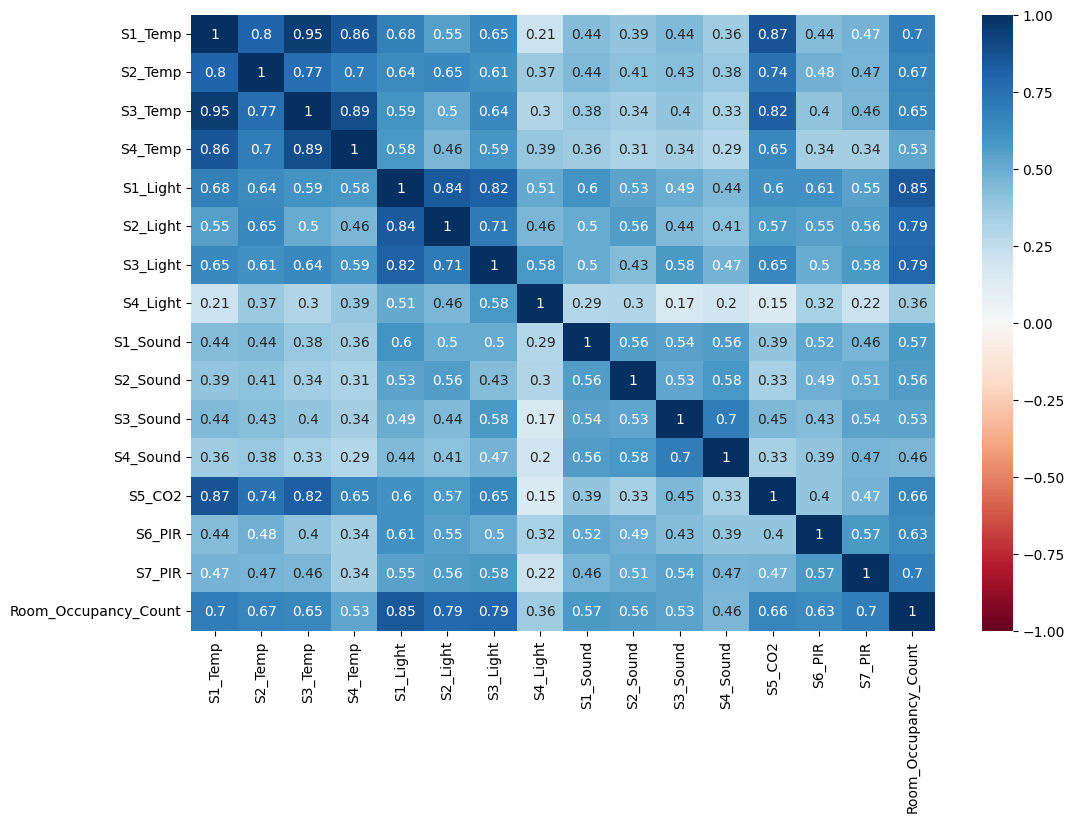

In [15]:
# In the data exploration and preprocessing step, we will work with df_v1 which is a copy of the original df
# Remove categorical / unclear data
# Date/Time is incorporated into Pandas DateTime, and CO2_Slope we recreate with delta CO2 in a separate dataframe
df_v1 = df.drop(columns=['Date', 'Time', 'S5_CO2_Slope'])
corr = df_v1.corr()

# Increase size of plot to fit all the values
plt.figure(figsize=(12, 8))
sns.heatmap(corr, vmin=-1, vmax=1, center=0, annot=True, cmap= 'RdBu')
# All positively correlated

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10129 entries, 0 to 10128
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   S1_Temp               10129 non-null  float64
 1   S2_Temp               10129 non-null  float64
 2   S3_Temp               10129 non-null  float64
 3   S4_Temp               10129 non-null  float64
 4   S1_Light              10129 non-null  int64  
 5   S2_Light              10129 non-null  int64  
 6   S3_Light              10129 non-null  int64  
 7   S4_Light              10129 non-null  int64  
 8   S1_Sound              10129 non-null  float64
 9   S2_Sound              10129 non-null  float64
 10  S3_Sound              10129 non-null  float64
 11  S4_Sound              10129 non-null  float64
 12  S5_CO2                10129 non-null  int64  
 13  S6_PIR                10129 non-null  int64  
 14  S7_PIR                10129 non-null  int64  
 15  Room_Occupancy_Coun

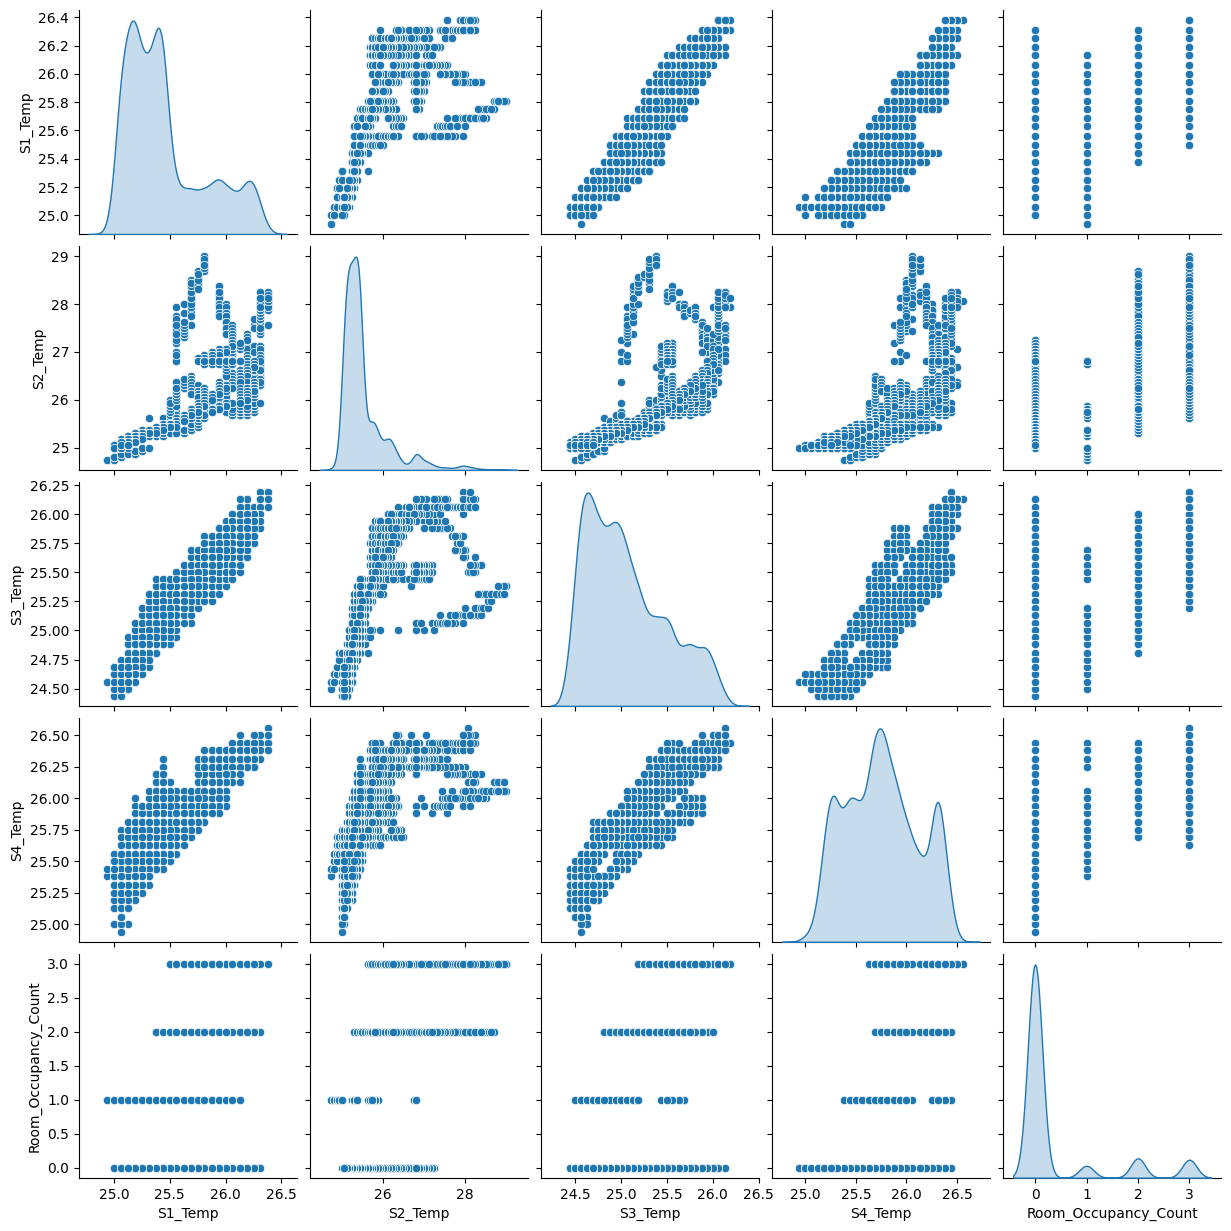

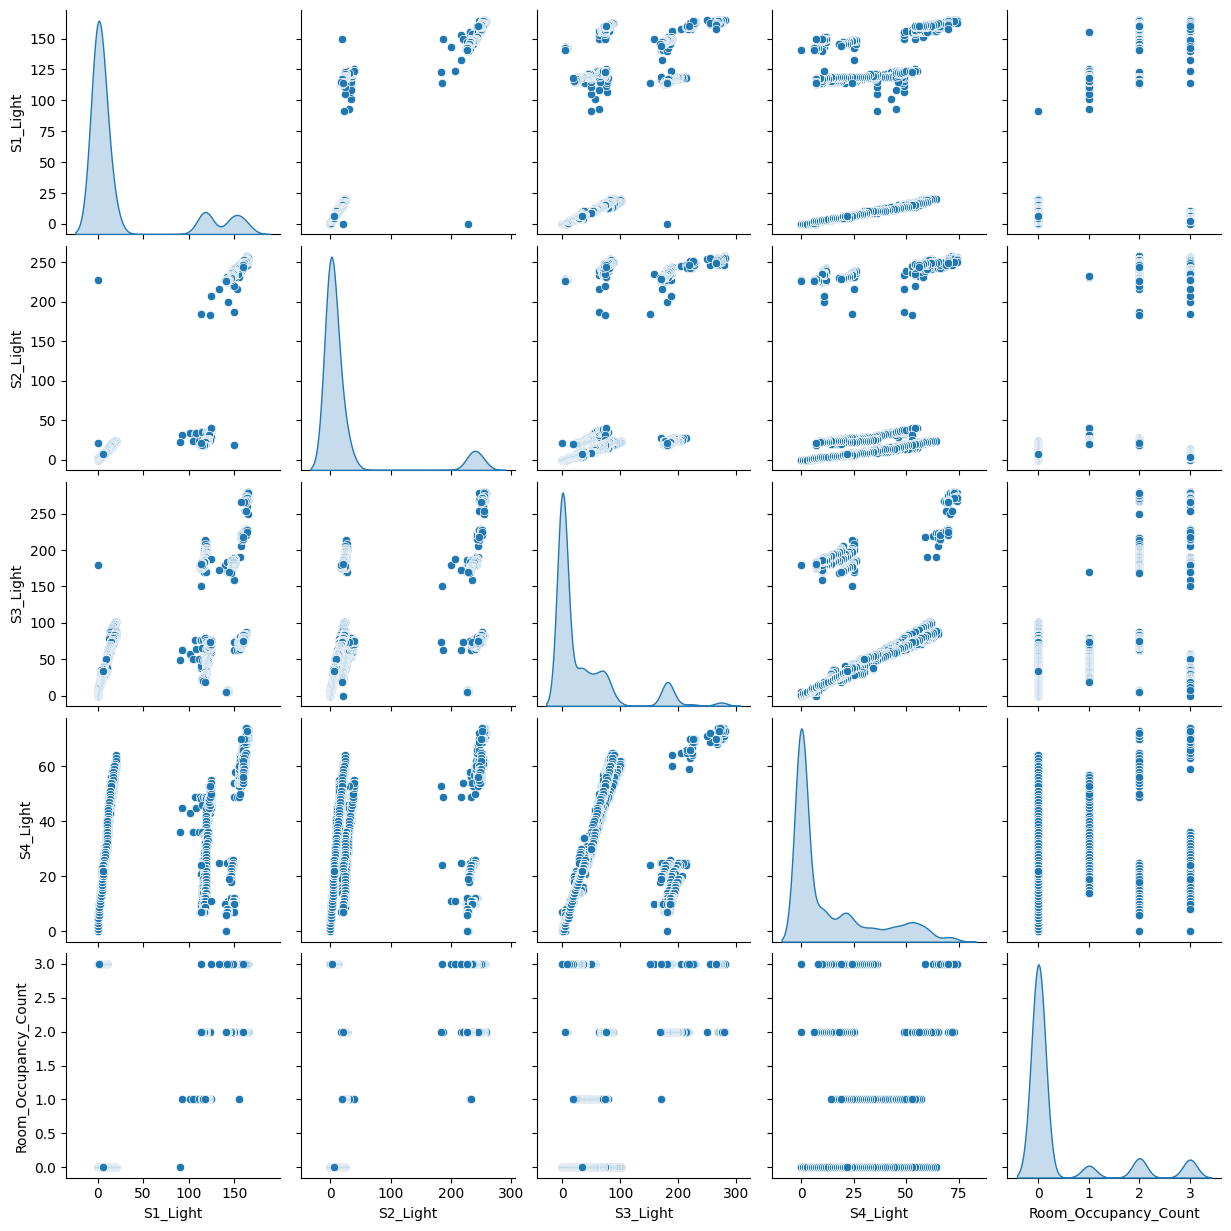

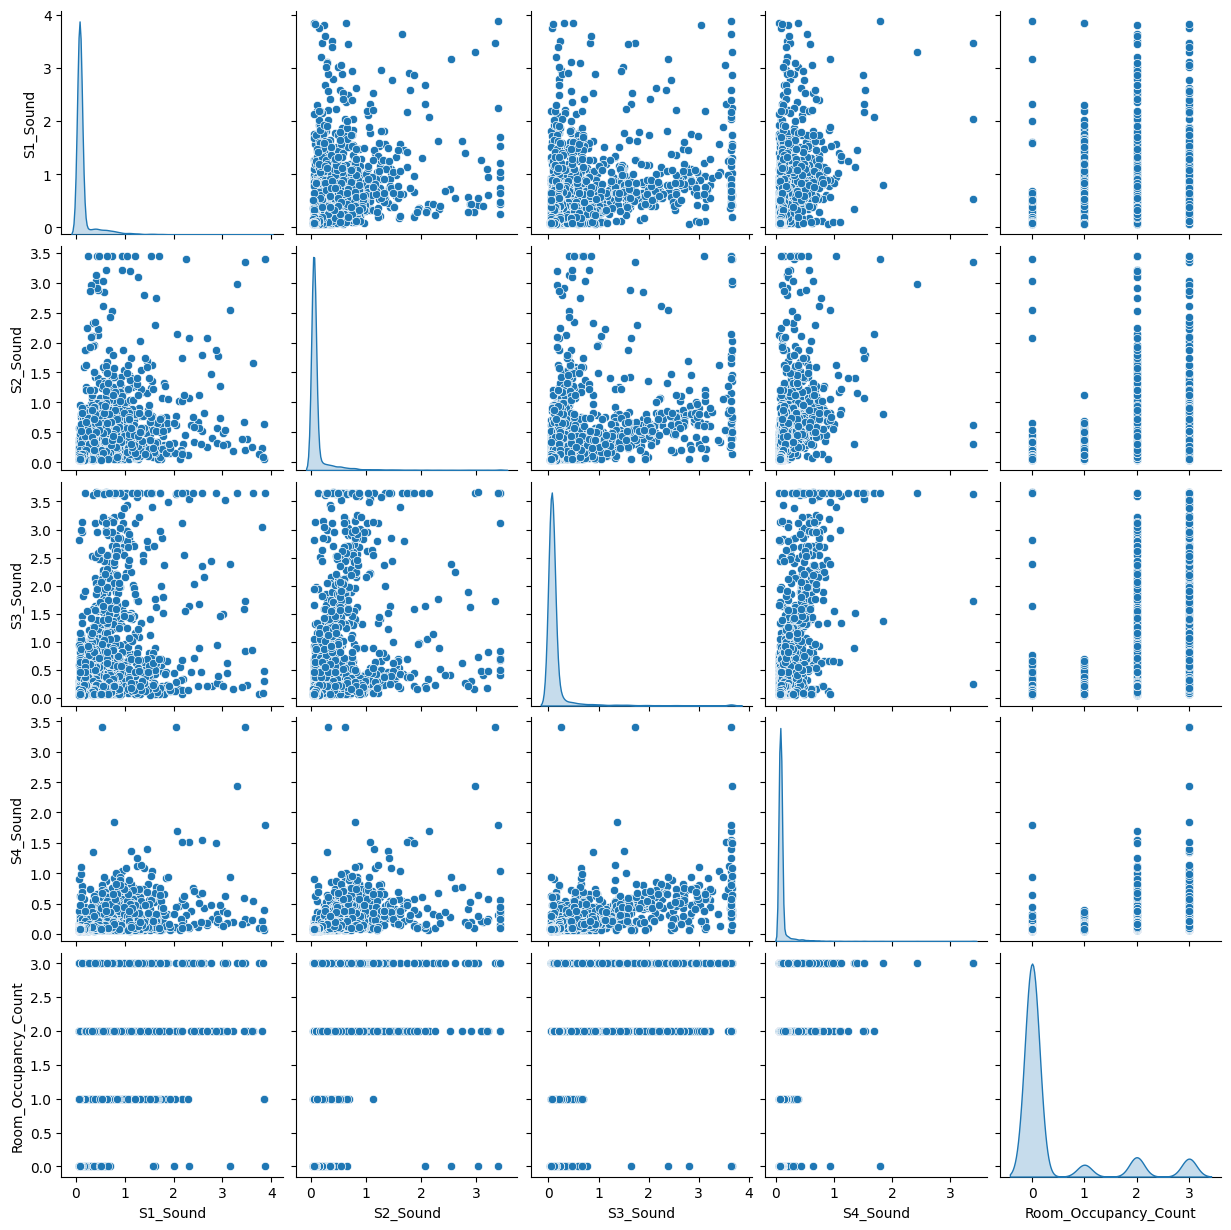

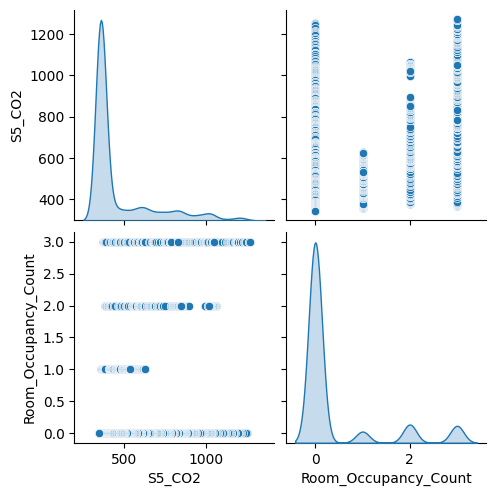

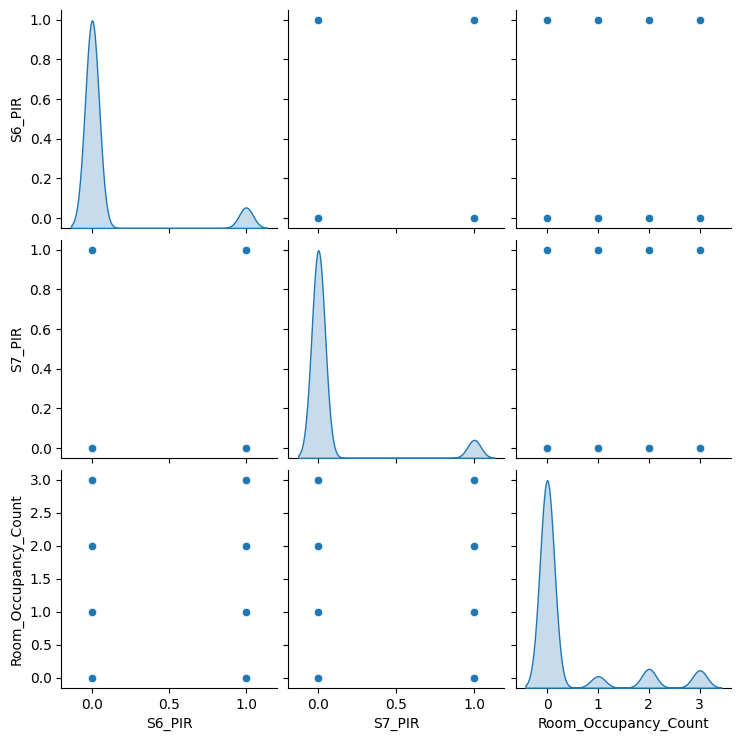

In [16]:
# Splitting the data into different types along with Room_Occupancy_Count (index 16)
df_v1.info()
df_temp = df_v1.iloc[:, [0, 1, 2, 3, 15]]
df_light = df_v1.iloc[:, [4, 5, 6, 7, 15]]
df_sound = df_v1.iloc[:, [8, 9, 10, 11, 15]]
df_co2 = df_v1.iloc[:, [12, 15]]
df_pir = df_v1.iloc[:, [13, 14, 15]]

# Scatterplots of our different data types grouped into 4 categories

# Temperature Scatter
sns.pairplot(df_temp, diag_kind='kde')
# Won't need transformation


# Light Scatter
sns.pairplot(df_light, diag_kind='kde')


# Sound Scatter
sns.pairplot(df_sound, diag_kind='kde')
# Data is slightly skewed and may benefit from a log transformation


# CO2 Scatter
sns.pairplot(df_co2, diag_kind='kde')

# PIR Scatter
sns.pairplot(df_pir, diag_kind='kde')


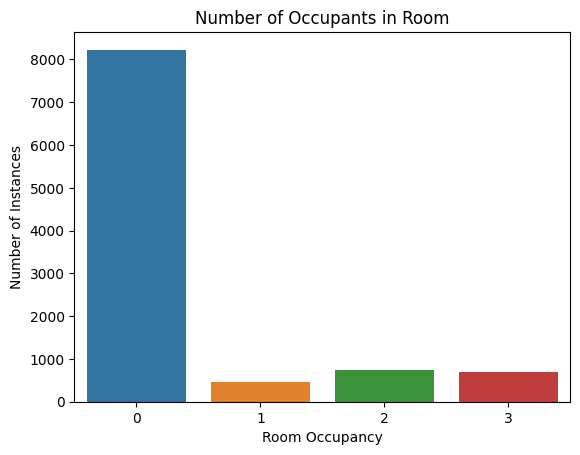

In [17]:
# Room occupancy count
unq_occupants = df['Room_Occupancy_Count'].value_counts().sort_index()
sns.barplot(x = unq_occupants.index, y = unq_occupants.values)
plt.ylabel('Number of Instances')
plt.xlabel('Room Occupancy')
plt.title('Number of Occupants in Room')
plt.show()

# Proportion of observations that had people inside the room during the measurement
occupants_proportion = (unq_occupants / (unq_occupants.sum())) * 100



#Data Preprocessing

In [26]:
# Now that we have explored the data and decided what preprocessing we might want to do (see README.md)
# We will resume using the original dataframe df instead of the copy df_v1 to do the preprocessing
# Convert time to datetime for easier plotting

df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

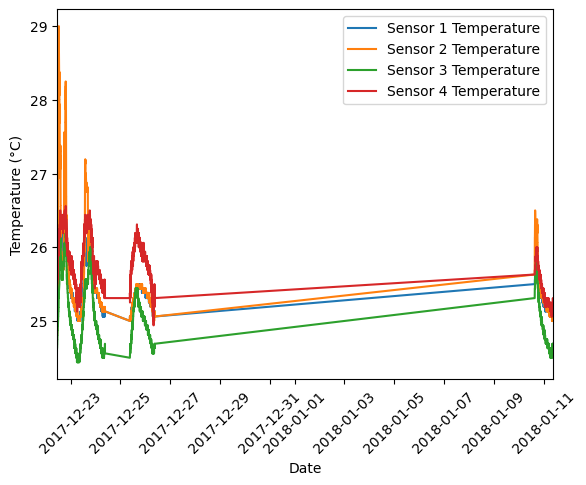

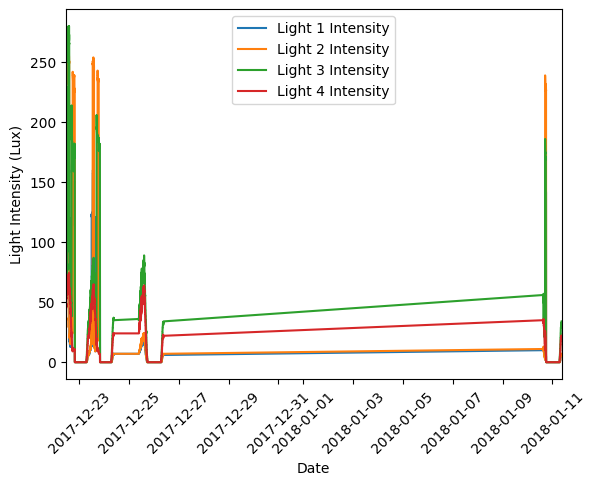

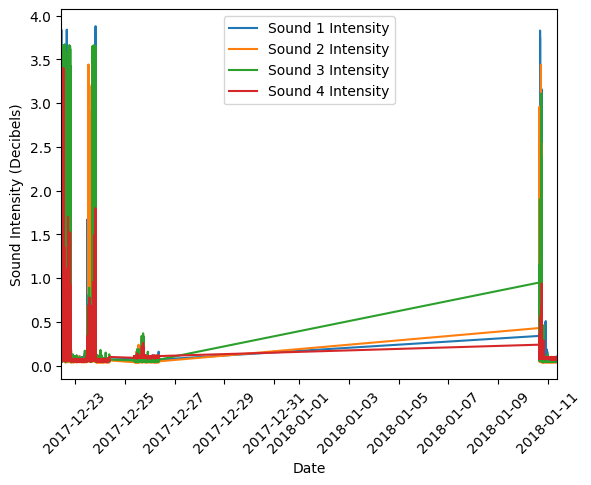

In [27]:
# Sensors S1-S4
# Temperature against DateTime
plt.plot(df['DateTime'], df['S1_Temp'])
plt.plot(df['DateTime'], df['S2_Temp'])
plt.plot(df['DateTime'], df['S3_Temp'])
plt.plot(df['DateTime'], df['S4_Temp'])
plt.legend(['Sensor 1 Temperature', 'Sensor 2 Temperature', 'Sensor 3 Temperature', 'Sensor 4 Temperature'])

plt.ylabel('Temperature (\u00b0C)')
plt.xlabel('Date')
plt.xlim(df['DateTime'].min(), df['DateTime'].max())
plt.xticks(rotation = 45)
plt.show()

# Light against DateTime
plt.plot(df['DateTime'], df['S1_Light'])
plt.plot(df['DateTime'], df['S2_Light'])
plt.plot(df['DateTime'], df['S3_Light'])
plt.plot(df['DateTime'], df['S4_Light'])
plt.legend(['Light 1 Intensity', 'Light 2 Intensity', 'Light 3 Intensity', 'Light 4 Intensity'])

plt.ylabel('Light Intensity (Lux)')
plt.xlabel('Date')
plt.xlim(df['DateTime'].min(), df['DateTime'].max())
plt.xticks(rotation = 45)
plt.show()

# Sound against DateTime
plt.plot(df['DateTime'], df['S1_Sound'])
plt.plot(df['DateTime'], df['S2_Sound'])
plt.plot(df['DateTime'], df['S3_Sound'])
plt.plot(df['DateTime'], df['S4_Sound'])
plt.legend(['Sound 1 Intensity', 'Sound 2 Intensity', 'Sound 3 Intensity', 'Sound 4 Intensity'])

plt.ylabel('Sound Intensity (Decibels)')
plt.xlabel('Date')
plt.xlim(df['DateTime'].min(), df['DateTime'].max())
plt.xticks(rotation = 45)
plt.show()

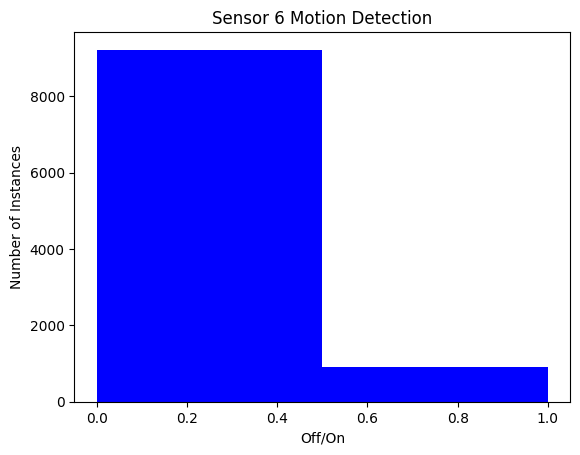

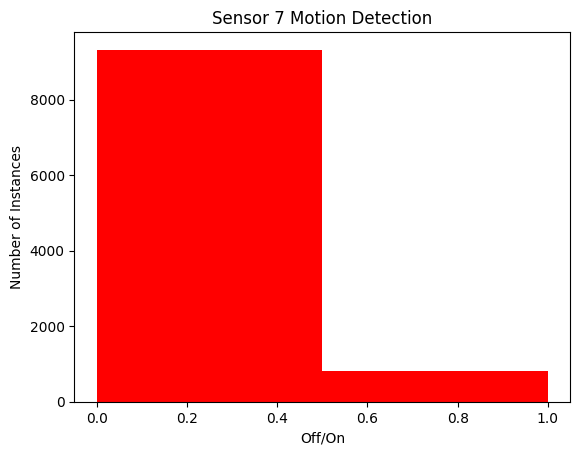

In [28]:
# Sensor 6 Motion Detection
plt.hist(df['S6_PIR'], bins = 2, color = 'blue')
plt.ylabel('Number of Instances')
plt.xlabel('Off/On')
plt.title('Sensor 6 Motion Detection')
s6_pir_percentage = (df['S6_PIR'] / (df['S6_PIR'].sum())) * 100
plt.show()

# Sensor 7 Motion Detection
plt.hist(df['S7_PIR'], bins = 2, color = 'red')
plt.ylabel('Number of Instances')
plt.xlabel('Off/On')
plt.title('Sensor 7 Motion Detection')
s7_pir_percentage = (df['S7_PIR'] / (df['S7_PIR'].sum())) * 100
plt.show()

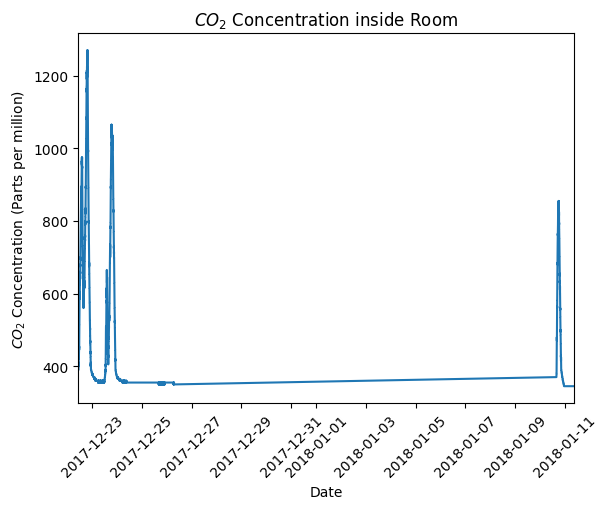

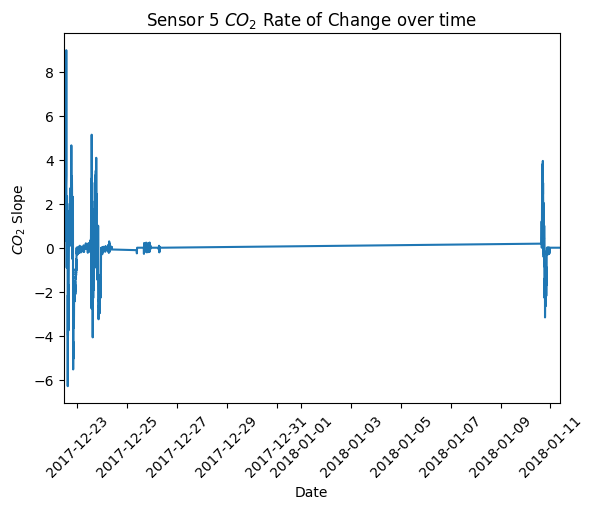

In [29]:
# CO2 Concentration Sensor
plt.plot(df['DateTime'], df['S5_CO2'])
plt.xlim(df['DateTime'].min(), df['DateTime'].max())
plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('$CO_{2}$ Concentration (Parts per million)')
plt.title('$CO_{2}$ Concentration inside Room')
plt.show()

# CO2 Slope
plt.plot(df['DateTime'], df['S5_CO2_Slope'])
plt.xlim(df['DateTime'].min(), df['DateTime'].max())
plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('$CO_{2}$ Slope')
plt.title('Sensor 5 $CO_{2}$ Rate of Change over time')
plt.show()

In [30]:
# Moving on to scaling -> dropping date and time before scaling numerical sensor output
dates = df['DateTime']
df = df.drop(columns = ['Date', 'Time', 'DateTime'])

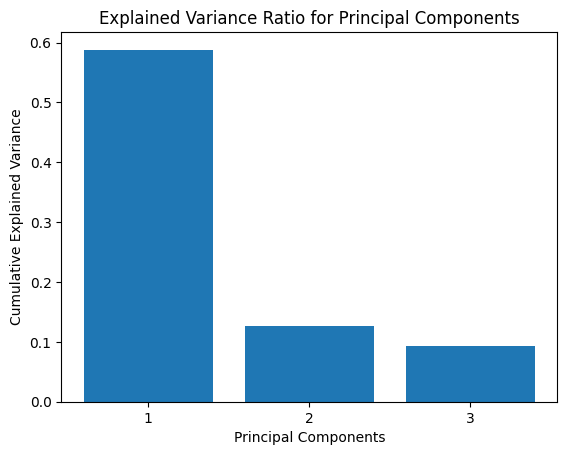

In [31]:
# Finishing up preprocessing of the data by standardizing inputs and encoding outputs
scaler = MinMaxScaler()
encoder = LabelBinarizer() # input categorical data and output numpy array

X = df.iloc[:, :-1] # get all columns except room_occupancy
y = df.iloc[:,-1] # room occupancy

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)

y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes = 4) # convert to categorical data for later analysis
y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes = 4) # convert to categorical data for later analysis

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
X_scaled = scaler.transform(X)

pca = PCA(n_components = 3) # reduce number of features in dataset from 17 to 4 with pca
reduced_x = pca.fit_transform(X_scaled)

reduced_x_train = pca.fit_transform(x_train_scaled)
reduced_x_test = pca.transform(x_test_scaled)

plt.bar(range(3), pca.explained_variance_ratio_)
plt.xticks(range(3), range(1,4)) # set x ticks to be equal to first 4 principal components
plt.xlabel('Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance Ratio for Principal Components')
plt.show()

# Data Modeling

In [34]:
models = {'Artificial Neural Network': Sequential(),
'Logistic Regression': LogisticRegression(),
'Decision Tree': DecisionTreeClassifier(),
'K-Nearest Neighbors': KNeighborsClassifier(),
'Support Vector Machine': SVC(),
'Random Forest': RandomForestClassifier(),
'Gradient Boosting': XGBClassifier()} # dictionary of models to iterate data through
res = [] # list to store results
looker = 0 # if 0, use normal scaled data; otherwise use pca data

for name, model in models.items(): # iterate through model dictionary for fittting
    if name == 'Artificial Neural Network':
        # run ann if its selected from model list
        model.add(Dense(units = 12, activation = 'sigmoid', input_dim = 16)) # input layer
        model.add(Dense(units = 3, activation = 'sigmoid'))
        model.add(Dense(units = 4, activation = 'softmax')) # output layer

        adjusted_sgd = SGD(learning_rate= 0.2) # set learning rate for gradient descent
        model.compile(optimizer= adjusted_sgd, loss = 'categorical_crossentropy')
        model.fit(x_train_scaled, y_train_encoded, epochs = 50)

        pred_train = model.predict(x_train_scaled)
        pred_test = model.predict(x_test_scaled) # store predictions that can be evaluated later in loop
        y_labels_train = np.argmax(pred_train, axis = 1)
        y_labels_test = np.argmax(pred_test, axis = 1)
        y_true_train = np.argmax(y_train_encoded, axis = 1)
        y_true_test = np.argmax(y_test_encoded, axis = 1)

        confused_mat_train = confusion_matrix(y_true_train, y_labels_train)
        class_rep_train = classification_report(y_true_train, y_labels_train)
        accuracy_rate_train = accuracy_score(y_true_train, y_labels_train)
        train_mse_score = mean_squared_error(y_true_train, y_labels_train)

        confused_mat_test = confusion_matrix(y_true_test, y_labels_test)
        class_rep_test = classification_report(y_true_test, y_labels_test)
        accuracy_rate_test = accuracy_score(y_true_test, y_labels_test)
        test_mse_score = mean_squared_error(y_true_test, y_labels_test)

        res.append((confused_mat_train, confused_mat_test, class_rep_train, class_rep_test, accuracy_rate_train, accuracy_rate_test, train_mse_score, test_mse_score))
    else:
        model.fit(x_train_scaled, y_train)
        pred_train = model.predict(x_train_scaled)
        pred_test = model.predict(x_test_scaled) # store predictions that can be evaluated later in loop

        confused_mat_train = confusion_matrix(y_train, pred_train) # create metrics to analyze later
        class_rep_train = classification_report(y_train, pred_train)
        accuracy_rate_train = accuracy_score(y_train, pred_train)
        train_mse_score = mean_squared_error(y_train, pred_train)

        confused_mat_test = confusion_matrix(y_test, pred_test)
        class_rep_test = classification_report(y_test, pred_test)
        accuracy_rate_test = accuracy_score(y_test, pred_test)
        test_mse_score = mean_squared_error(y_test, pred_test)

        res.append((confused_mat_train, confused_mat_test, class_rep_train, class_rep_test, accuracy_rate_train, accuracy_rate_test, train_mse_score, test_mse_score))




Epoch 1/50
254/254 [==============================] - 2s 4ms/step - loss: 0.6795
Epoch 2/50
254/254 [==============================] - 1s 4ms/step - loss: 0.5409
Epoch 3/50
254/254 [==============================] - 1s 6ms/step - loss: 0.3277
Epoch 4/50
254/254 [==============================] - 1s 3ms/step - loss: 0.2625
Epoch 5/50
254/254 [==============================] - 1s 5ms/step - loss: 0.2434
Epoch 6/50
254/254 [==============================] - 1s 3ms/step - loss: 0.2337
Epoch 7/50
254/254 [==============================] - 1s 4ms/step - loss: 0.2266
Epoch 8/50
254/254 [==============================] - 2s 8ms/step - loss: 0.2211
Epoch 9/50
254/254 [==============================] - 1s 4ms/step - loss: 0.2148
Epoch 10/50
254/254 [==============================] - 1s 5ms/step - loss: 0.2080
Epoch 11/50
254/254 [==============================] - 1s 5ms/step - loss: 0.1999
Epoch 12/50
254/254 [==============================] - 1s 2ms/step - loss: 0.1919
Epoch 13/50
254/254 [====

In [35]:
models2 = {'Artificial Neural Network': Sequential(),
'Logistic Regression': LogisticRegression(),
'Decision Tree': DecisionTreeClassifier(),
'K-Nearest Neighbors': KNeighborsClassifier(),
'Support Vector Machine': SVC(),
'Random Forest': RandomForestClassifier(),
'Gradient Boosting': XGBClassifier()} # dictionary of models to iterate data through


res_pca = []
for name, model in models2.items(): # iterate through model dictionary for fittting
    x_train_scaled, x_test_scaled = reduced_x_train, reduced_x_test # redefine x test and train for pca

    # redefine scaled x_train and test for pca data
    if name == 'Artificial Neural Network':
        # run ann if its selected from model list
        model.add(Dense(units = 12, activation = 'sigmoid', input_dim = 3)) # input layer
        model.add(Dense(units = 3, activation = 'sigmoid'))
        model.add(Dense(units = 4, activation = 'softmax')) # output layer

        adjusted_sgd = SGD(learning_rate= 0.2) # set learning rate for gradient descent
        model.compile(optimizer= adjusted_sgd, loss = 'categorical_crossentropy')
        model.fit(x_train_scaled, y_train_encoded, epochs = 50)

        pred_train = model.predict(x_train_scaled)
        pred_test = model.predict(x_test_scaled) # store predictions that can be evaluated later in loop
        y_labels_train = np.argmax(pred_train, axis = 1)
        y_labels_test = np.argmax(pred_test, axis = 1)
        y_true_train = np.argmax(y_train_encoded, axis = 1)
        y_true_test = np.argmax(y_test_encoded, axis = 1)

        confused_mat_train = confusion_matrix(y_true_train, y_labels_train)
        class_rep_train = classification_report(y_true_train, y_labels_train)
        accuracy_rate_train = accuracy_score(y_true_train, y_labels_train)
        train_mse_score = mean_squared_error(y_true_train, y_labels_train)

        confused_mat_test = confusion_matrix(y_true_test, y_labels_test)
        class_rep_test = classification_report(y_true_test, y_labels_test)
        accuracy_rate_test = accuracy_score(y_true_test, y_labels_test)
        test_mse_score = mean_squared_error(y_true_test, y_labels_test)

        res_pca.append((confused_mat_train, confused_mat_test, class_rep_train, class_rep_test, accuracy_rate_train, accuracy_rate_test, train_mse_score, test_mse_score))
    else:
        model.fit(x_train_scaled, y_train)
        pred_train = model.predict(x_train_scaled)
        pred_test = model.predict(x_test_scaled) # store predictions that can be evaluated later in loop

        confused_mat_train = confusion_matrix(y_train, pred_train) # create metrics to analyze later
        class_rep_train = classification_report(y_train, pred_train)
        accuracy_rate_train = accuracy_score(y_train, pred_train)
        train_mse_score = mean_squared_error(y_train, pred_train)

        confused_mat_test = confusion_matrix(y_test, pred_test)
        class_rep_test = classification_report(y_test, pred_test)
        accuracy_rate_test = accuracy_score(y_test, pred_test)
        test_mse_score = mean_squared_error(y_test, pred_test)

        res_pca.append((confused_mat_train, confused_mat_test, class_rep_train, class_rep_test, accuracy_rate_train, accuracy_rate_test, train_mse_score, test_mse_score))


Epoch 1/50
254/254 [==============================] - 1s 2ms/step - loss: 0.6407
Epoch 2/50
254/254 [==============================] - 0s 2ms/step - loss: 0.3847
Epoch 3/50
254/254 [==============================] - 0s 2ms/step - loss: 0.2880
Epoch 4/50
254/254 [==============================] - 0s 2ms/step - loss: 0.2632
Epoch 5/50
254/254 [==============================] - 0s 2ms/step - loss: 0.2515
Epoch 6/50
254/254 [==============================] - 0s 2ms/step - loss: 0.2439
Epoch 7/50
254/254 [==============================] - 0s 2ms/step - loss: 0.2389
Epoch 8/50
254/254 [==============================] - 0s 2ms/step - loss: 0.2348
Epoch 9/50
254/254 [==============================] - 0s 2ms/step - loss: 0.2309
Epoch 10/50
254/254 [==============================] - 0s 2ms/step - loss: 0.2276
Epoch 11/50
254/254 [==============================] - 0s 2ms/step - loss: 0.2241
Epoch 12/50
254/254 [==============================] - 0s 2ms/step - loss: 0.2207
Epoch 13/50
254/254 [====

#Model Results

Results for Artificial Neural Network


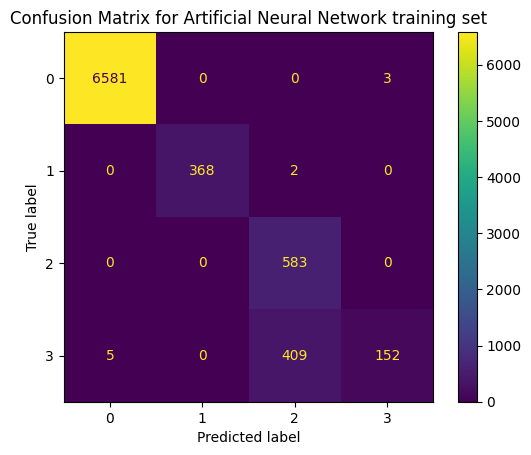

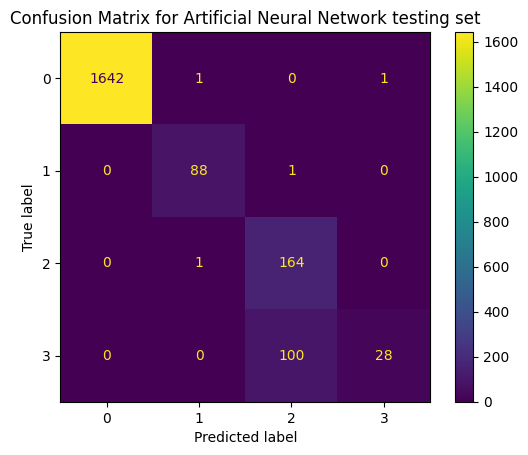

Classification report for Artificial Neural Network training set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6584
           1       1.00      0.99      1.00       370
           2       0.59      1.00      0.74       583
           3       0.98      0.27      0.42       566

    accuracy                           0.95      8103
   macro avg       0.89      0.82      0.79      8103
weighted avg       0.97      0.95      0.94      8103

Classification report for Artificial Neural Network testing set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1644
           1       0.98      0.99      0.98        89
           2       0.62      0.99      0.76       165
           3       0.97      0.22      0.36       128

    accuracy                           0.95      2026
   macro avg       0.89      0.80      0.78      2026
weighted avg       0.97      0.95      0.94      202

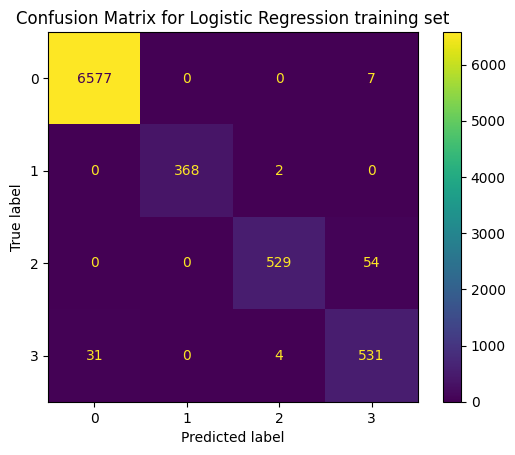

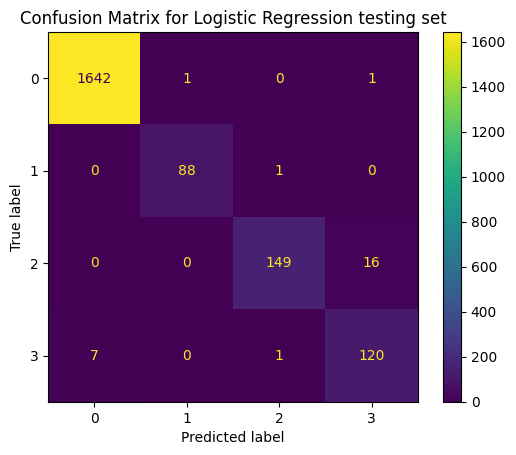

Classification report for Logistic Regression training set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6584
           1       1.00      0.99      1.00       370
           2       0.99      0.91      0.95       583
           3       0.90      0.94      0.92       566

    accuracy                           0.99      8103
   macro avg       0.97      0.96      0.96      8103
weighted avg       0.99      0.99      0.99      8103

Classification report for Logistic Regression testing set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1644
           1       0.99      0.99      0.99        89
           2       0.99      0.90      0.94       165
           3       0.88      0.94      0.91       128

    accuracy                           0.99      2026
   macro avg       0.96      0.96      0.96      2026
weighted avg       0.99      0.99      0.99      2026

Accuracy 

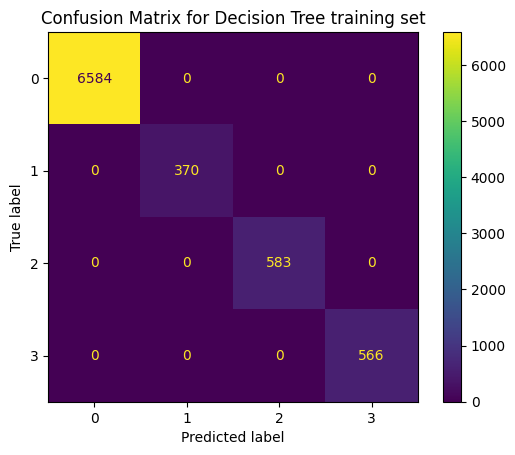

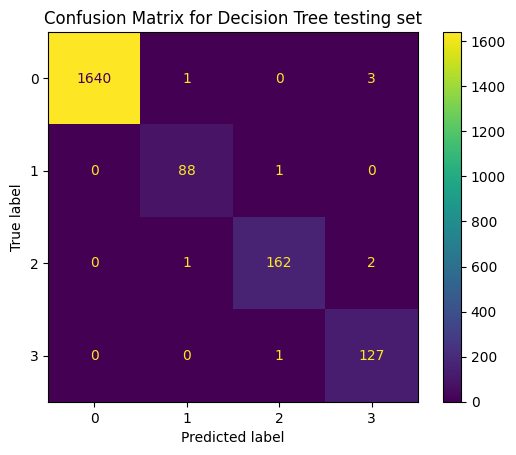

Classification report for Decision Tree training set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6584
           1       1.00      1.00      1.00       370
           2       1.00      1.00      1.00       583
           3       1.00      1.00      1.00       566

    accuracy                           1.00      8103
   macro avg       1.00      1.00      1.00      8103
weighted avg       1.00      1.00      1.00      8103

Classification report for Decision Tree testing set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1644
           1       0.98      0.99      0.98        89
           2       0.99      0.98      0.98       165
           3       0.96      0.99      0.98       128

    accuracy                           1.00      2026
   macro avg       0.98      0.99      0.99      2026
weighted avg       1.00      1.00      1.00      2026

Accuracy Score for De

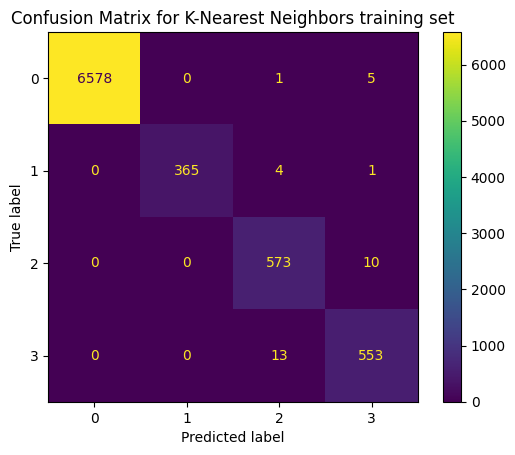

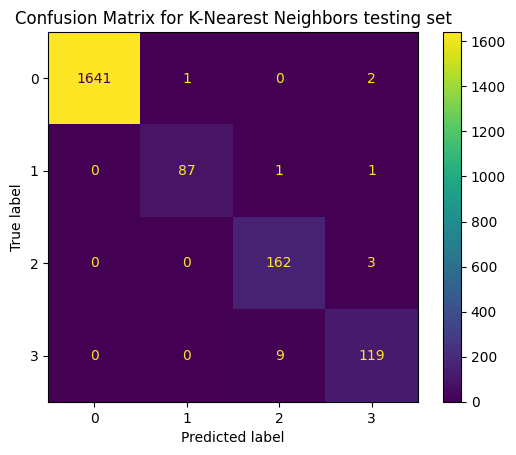

Classification report for K-Nearest Neighbors training set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6584
           1       1.00      0.99      0.99       370
           2       0.97      0.98      0.98       583
           3       0.97      0.98      0.97       566

    accuracy                           1.00      8103
   macro avg       0.99      0.99      0.99      8103
weighted avg       1.00      1.00      1.00      8103

Classification report for K-Nearest Neighbors testing set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1644
           1       0.99      0.98      0.98        89
           2       0.94      0.98      0.96       165
           3       0.95      0.93      0.94       128

    accuracy                           0.99      2026
   macro avg       0.97      0.97      0.97      2026
weighted avg       0.99      0.99      0.99      2026

Accuracy 

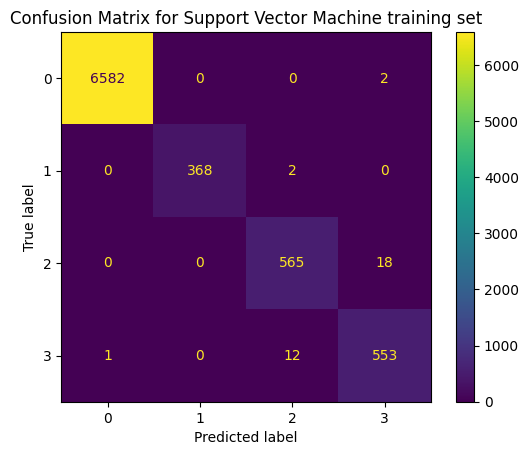

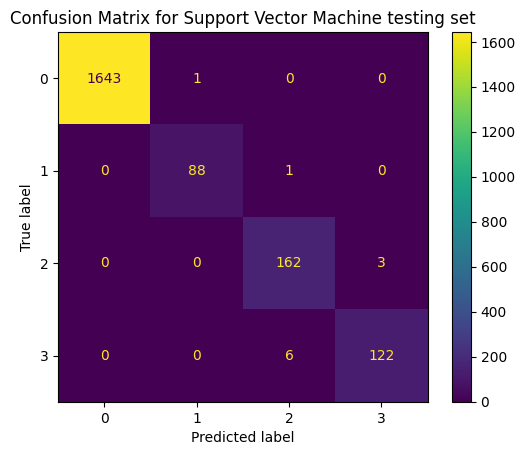

Classification report for Support Vector Machine training set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6584
           1       1.00      0.99      1.00       370
           2       0.98      0.97      0.97       583
           3       0.97      0.98      0.97       566

    accuracy                           1.00      8103
   macro avg       0.99      0.99      0.99      8103
weighted avg       1.00      1.00      1.00      8103

Classification report for Support Vector Machine testing set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1644
           1       0.99      0.99      0.99        89
           2       0.96      0.98      0.97       165
           3       0.98      0.95      0.96       128

    accuracy                           0.99      2026
   macro avg       0.98      0.98      0.98      2026
weighted avg       0.99      0.99      0.99      2026

Acc

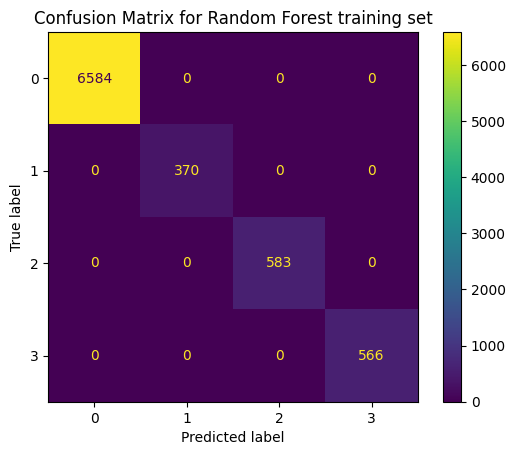

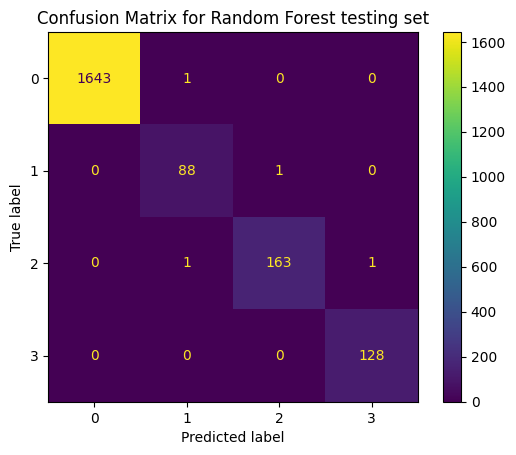

Classification report for Random Forest training set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6584
           1       1.00      1.00      1.00       370
           2       1.00      1.00      1.00       583
           3       1.00      1.00      1.00       566

    accuracy                           1.00      8103
   macro avg       1.00      1.00      1.00      8103
weighted avg       1.00      1.00      1.00      8103

Classification report for Random Forest testing set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1644
           1       0.98      0.99      0.98        89
           2       0.99      0.99      0.99       165
           3       0.99      1.00      1.00       128

    accuracy                           1.00      2026
   macro avg       0.99      0.99      0.99      2026
weighted avg       1.00      1.00      1.00      2026

Accuracy Score for Ra

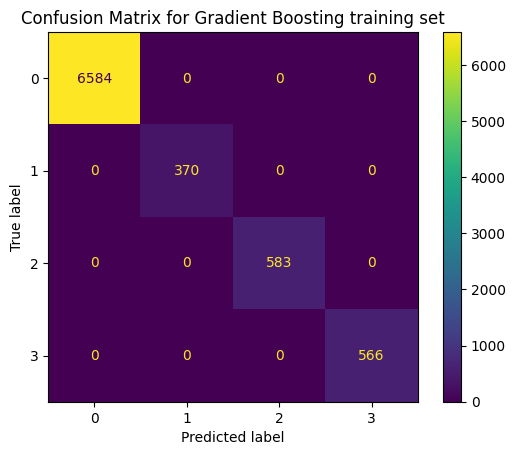

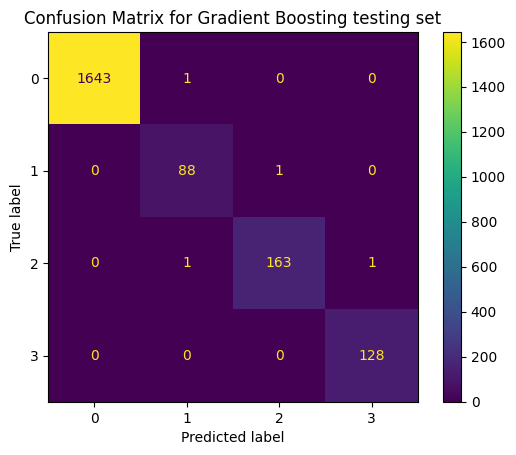

Classification report for Gradient Boosting training set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6584
           1       1.00      1.00      1.00       370
           2       1.00      1.00      1.00       583
           3       1.00      1.00      1.00       566

    accuracy                           1.00      8103
   macro avg       1.00      1.00      1.00      8103
weighted avg       1.00      1.00      1.00      8103

Classification report for Gradient Boosting testing set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1644
           1       0.98      0.99      0.98        89
           2       0.99      0.99      0.99       165
           3       0.99      1.00      1.00       128

    accuracy                           1.00      2026
   macro avg       0.99      0.99      0.99      2026
weighted avg       1.00      1.00      1.00      2026

Accuracy Scor

In [44]:
model_names = pd.DataFrame(models.keys())
for i,r in enumerate(res):
    model_name = model_names.iloc[i,0]
    print(f'Results for {model_name}')
    print("======================================================================================================================================")
    con_matrix_train, con_matrix_test, class_report_train, class_report_test, accuracy_train, accuracy_test, mse_train, mse_test = r # redefine results for loop
    matrix_on_display_train = ConfusionMatrixDisplay(con_matrix_train).plot() # plot confusion matrix
    plt.title(f'Confusion Matrix for {model_name} training set')
    plt.show()

    matrix_on_display_test = ConfusionMatrixDisplay(con_matrix_test).plot() # plot confusion matrix
    plt.title(f'Confusion Matrix for {model_name} testing set')
    plt.show()

    print(f'Classification report for {model_name} training set:\n {class_report_train}')
    print(f'Classification report for {model_name} testing set:\n {class_report_test}')
    print(f'Accuracy Score for {model_name} training set: {accuracy_train}\n')
    print(f'Accuracy Score for {model_name} testing set: {accuracy_test}\n')
    print(f'Mean Squared Error for {model_name} training set: {mse_train}\n')
    print(f'Mean Squared Error for {model_name} testing set: {mse_test}\n')



PCA Results for Artificial Neural Network


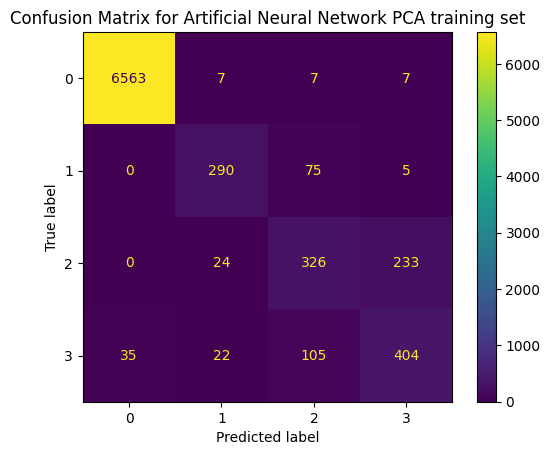

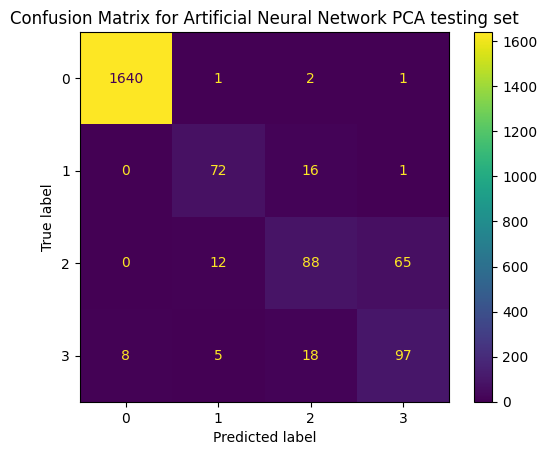

Classification report for Artificial Neural Network PCA training set:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      6584
           1       0.85      0.78      0.81       370
           2       0.64      0.56      0.59       583
           3       0.62      0.71      0.67       566

    accuracy                           0.94      8103
   macro avg       0.77      0.76      0.77      8103
weighted avg       0.94      0.94      0.94      8103

Classification report for Artificial Neural Network PCA testing set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1644
           1       0.80      0.81      0.80        89
           2       0.71      0.53      0.61       165
           3       0.59      0.76      0.66       128

    accuracy                           0.94      2026
   macro avg       0.77      0.77      0.77      2026
weighted avg       0.94      0.94      0.94 

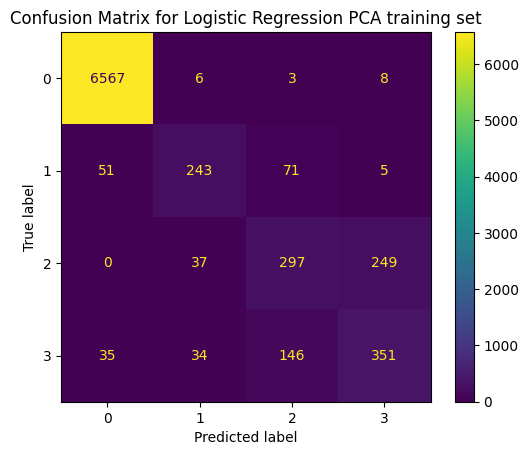

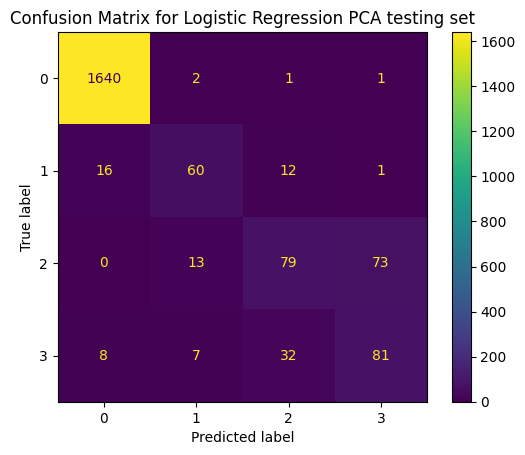

Classification report for Logistic Regression PCA training set:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      6584
           1       0.76      0.66      0.70       370
           2       0.57      0.51      0.54       583
           3       0.57      0.62      0.60       566

    accuracy                           0.92      8103
   macro avg       0.72      0.70      0.71      8103
weighted avg       0.92      0.92      0.92      8103

Classification report for Logistic Regression PCA testing set:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1644
           1       0.73      0.67      0.70        89
           2       0.64      0.48      0.55       165
           3       0.52      0.63      0.57       128

    accuracy                           0.92      2026
   macro avg       0.72      0.70      0.70      2026
weighted avg       0.92      0.92      0.92      2026

A

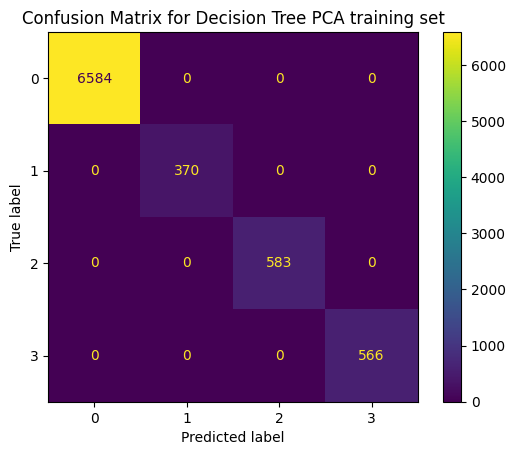

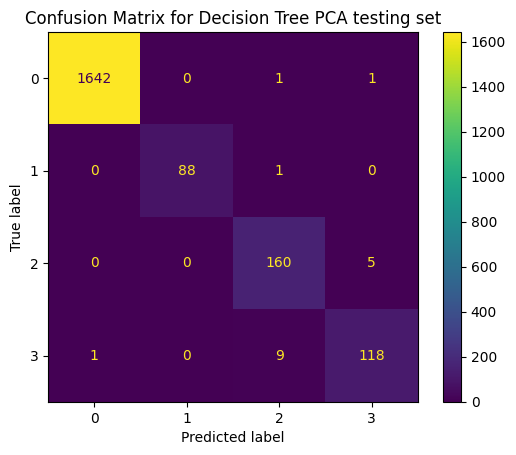

Classification report for Decision Tree PCA training set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6584
           1       1.00      1.00      1.00       370
           2       1.00      1.00      1.00       583
           3       1.00      1.00      1.00       566

    accuracy                           1.00      8103
   macro avg       1.00      1.00      1.00      8103
weighted avg       1.00      1.00      1.00      8103

Classification report for Decision Tree PCA testing set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1644
           1       1.00      0.99      0.99        89
           2       0.94      0.97      0.95       165
           3       0.95      0.92      0.94       128

    accuracy                           0.99      2026
   macro avg       0.97      0.97      0.97      2026
weighted avg       0.99      0.99      0.99      2026

Accuracy Scor

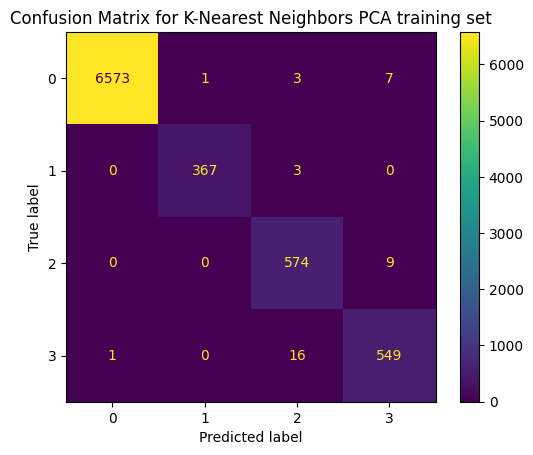

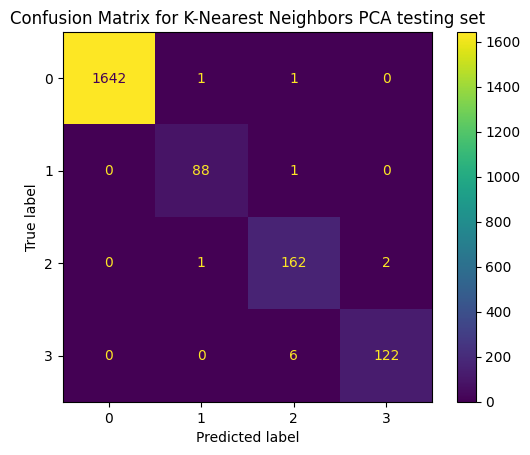

Classification report for K-Nearest Neighbors PCA training set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6584
           1       1.00      0.99      0.99       370
           2       0.96      0.98      0.97       583
           3       0.97      0.97      0.97       566

    accuracy                           1.00      8103
   macro avg       0.98      0.99      0.98      8103
weighted avg       1.00      1.00      1.00      8103

Classification report for K-Nearest Neighbors PCA testing set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1644
           1       0.98      0.99      0.98        89
           2       0.95      0.98      0.97       165
           3       0.98      0.95      0.97       128

    accuracy                           0.99      2026
   macro avg       0.98      0.98      0.98      2026
weighted avg       0.99      0.99      0.99      2026

A

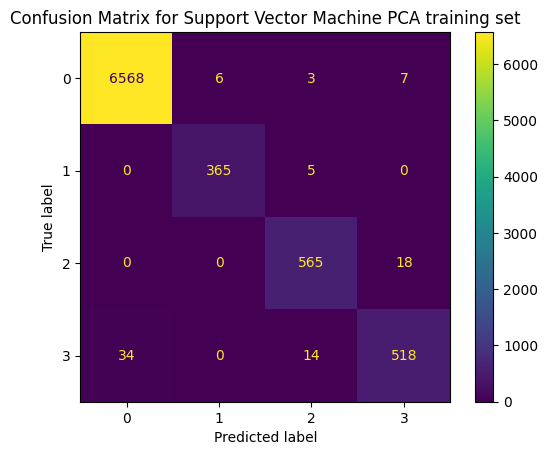

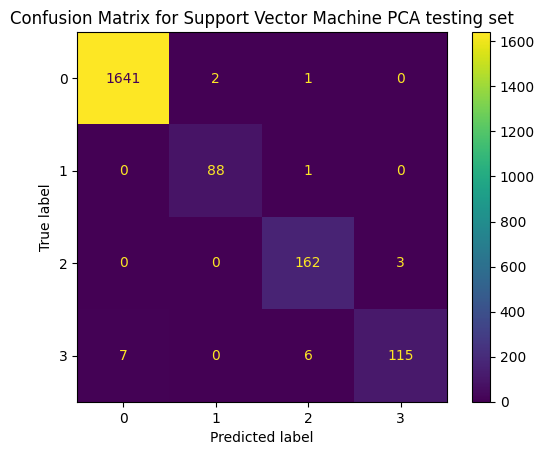

Classification report for Support Vector Machine PCA training set:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      6584
           1       0.98      0.99      0.99       370
           2       0.96      0.97      0.97       583
           3       0.95      0.92      0.93       566

    accuracy                           0.99      8103
   macro avg       0.97      0.97      0.97      8103
weighted avg       0.99      0.99      0.99      8103

Classification report for Support Vector Machine PCA testing set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1644
           1       0.98      0.99      0.98        89
           2       0.95      0.98      0.97       165
           3       0.97      0.90      0.93       128

    accuracy                           0.99      2026
   macro avg       0.98      0.97      0.97      2026
weighted avg       0.99      0.99      0.99      2

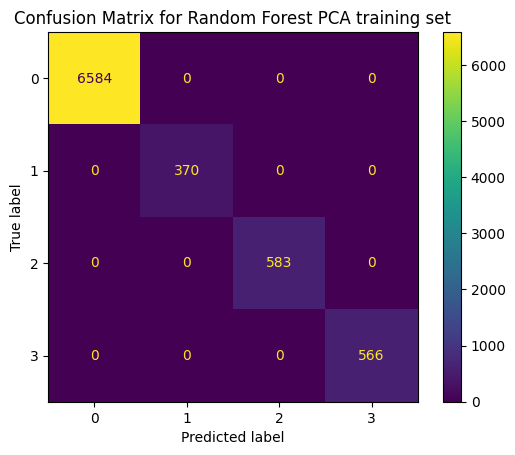

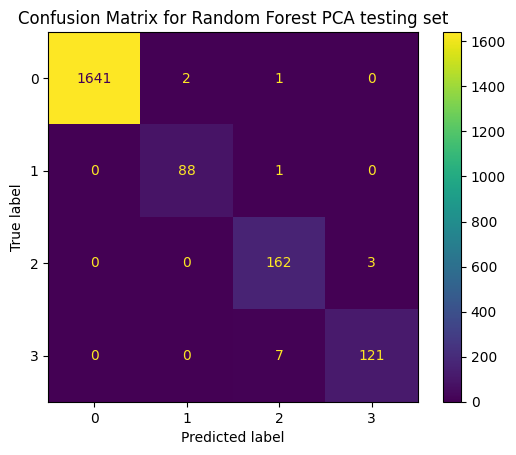

Classification report for Random Forest PCA training set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6584
           1       1.00      1.00      1.00       370
           2       1.00      1.00      1.00       583
           3       1.00      1.00      1.00       566

    accuracy                           1.00      8103
   macro avg       1.00      1.00      1.00      8103
weighted avg       1.00      1.00      1.00      8103

Classification report for Random Forest PCA testing set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1644
           1       0.98      0.99      0.98        89
           2       0.95      0.98      0.96       165
           3       0.98      0.95      0.96       128

    accuracy                           0.99      2026
   macro avg       0.98      0.98      0.98      2026
weighted avg       0.99      0.99      0.99      2026

Accuracy Scor

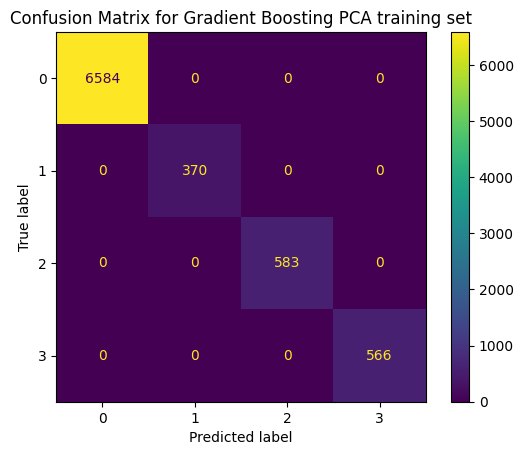

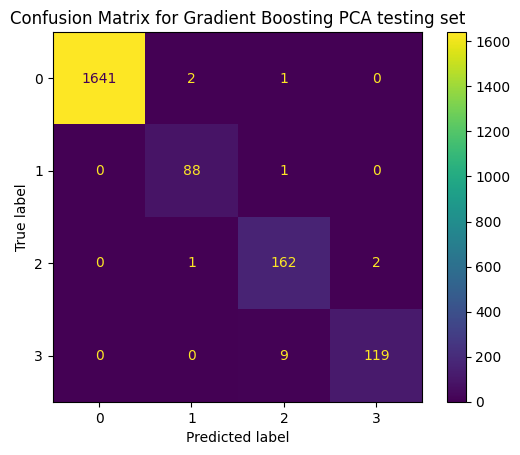

Classification report for Gradient Boosting PCA training set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6584
           1       1.00      1.00      1.00       370
           2       1.00      1.00      1.00       583
           3       1.00      1.00      1.00       566

    accuracy                           1.00      8103
   macro avg       1.00      1.00      1.00      8103
weighted avg       1.00      1.00      1.00      8103

Classification report for Gradient Boosting PCA testing set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1644
           1       0.97      0.99      0.98        89
           2       0.94      0.98      0.96       165
           3       0.98      0.93      0.96       128

    accuracy                           0.99      2026
   macro avg       0.97      0.97      0.97      2026
weighted avg       0.99      0.99      0.99      2026

Accur

In [48]:
model_names2 = pd.DataFrame(models2.keys())
for i,r in enumerate(res_pca):
    model_name = model_names2.iloc[i,0]
    print(f'PCA Results for {model_name}')
    print("======================================================================================================================================")
    con_matrix_train, con_matrix_test, class_report_train, class_report_test,  accuracy_train, accuracy_test, mse_train, mse_test = r # redefine results for loop

    matrix_on_display_train = ConfusionMatrixDisplay(con_matrix_train).plot() # plot confusion matrix
    plt.title(f'Confusion Matrix for {model_name} PCA training set')
    plt.show()

    matrix_on_display_test = ConfusionMatrixDisplay(con_matrix_test).plot() # plot confusion matrix
    plt.title(f'Confusion Matrix for {model_name} PCA testing set')
    plt.show()

    print(f'Classification report for {model_name} PCA training set:\n {class_report_train}')
    print(f'Classification report for {model_name} PCA testing set:\n {class_report_test}')
    print(f'Accuracy Score for {model_name} PCA training set: {accuracy_train}\n')
    print(f'Accuracy Score for {model_name} PCA testing set: {accuracy_test}\n')
    print(f'Mean Squared Error for {model_name} PCA training set: {mse_train}\n')
    print(f'Mean Squared Error for {model_name} PCA testing set: {mse_test}\n')
